# Training a single-task regression model for neural crest cells

In [42]:
import numpy as np
import pandas as pd
import torch
from utils import quantile_normalize

## Load Data

In [43]:
peaks = pd.read_csv("../data/psd.bulk.zfish_atac.10hpf.lg1x.csv")
peaks.head()

,anterior/posterior axis,central nervous system,forebrain,immature eye,integument,lateral plate mesoderm,mesenchyme cell,musculature system,neural crest,neural keel,neural stem cell,periderm/epidermis,primary neuron,segmental plate,YSL
0,4.612648,5.204557,3.391132,4.552681,3.668004,4.766655,4.012215,4.486644,4.463738,4.861570,3.614023,3.696712,3.210026,4.679626,4.277916
1,4.721959,5.358137,3.557652,4.688727,3.546239,4.748463,4.012215,4.399901,4.690443,4.848311,3.776074,3.959122,3.531244,4.750276,4.439449
2,4.806994,5.338711,3.360469,4.163852,3.668004,4.955051,4.129443,4.353534,4.787046,4.735389,3.574781,4.325414,4.545861,4.917399,5.058778
3,4.879061,5.578282,4.236443,4.404106,4.145129,4.893466,4.429041,4.558759,4.650654,4.885431,4.076645,4.572297,4.306987,5.019714,4.859518
4,5.052703,5.736003,4.323331,4.790483,4.440677,5.033977,4.375875,4.868698,5.025405,5.054618,4.130548,4.473848,4.426082,5.211885,5.306444


In [44]:
normalized_peaks = quantile_normalize(peaks)
normalized_peaks.head()

,anterior/posterior axis,central nervous system,forebrain,immature eye,integument,lateral plate mesoderm,mesenchyme cell,musculature system,neural crest,neural keel,neural stem cell,periderm/epidermis,primary neuron,segmental plate,YSL
0,4.651118,4.533672,3.743376,4.676512,3.889194,4.770185,4.072143,4.646133,4.503845,4.800124,3.992231,3.649010,3.416853,4.705932,3.646850
1,4.759777,4.715077,3.890921,4.802952,3.759139,4.749729,4.072143,4.552959,4.733108,4.789694,4.125601,3.914057,3.761764,4.784057,3.768121
2,4.844335,4.693973,3.715317,4.321034,3.889194,4.966067,4.201415,4.498629,4.829205,4.681877,3.960696,4.278734,4.914163,4.961720,4.249963
3,4.913120,4.970389,4.502000,4.538608,4.406436,4.899320,4.528167,4.722845,4.691382,4.822941,4.370635,4.526288,4.642561,5.065575,4.093085
4,5.091230,5.155606,4.580807,4.896827,4.731492,5.045142,4.468658,5.062934,5.069928,4.984374,4.415342,4.427255,4.779665,5.265965,4.454447


In [45]:
normalized_peaks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 370058 entries, 0 to 370057
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   anterior/posterior axis  370058 non-null  float64
 1   central nervous system   370058 non-null  float64
 2   forebrain                370058 non-null  float64
 3   immature eye             370058 non-null  float64
 4   integument               370058 non-null  float64
 5   lateral plate mesoderm   370058 non-null  float64
 6   mesenchyme cell          370058 non-null  float64
 7   musculature system       370058 non-null  float64
 8   neural crest             370058 non-null  float64
 9   neural keel              370058 non-null  float64
 10  neural stem cell         370058 non-null  float64
 11  periderm/epidermis       370058 non-null  float64
 12  primary neuron           370058 non-null  float64
 13  segmental plate          370058 non-null  float64
 14  YSL      

In [46]:
bed_data = pd.read_csv("../data/chromosomes.10hpf.bed", sep = '\t', header = None)
bed_data.columns = ['chrom', 'start', 'end', 'name', 'score', 'strand']
bed_data.head()

,chrom,start,end,name,score,strand
0,chr1,5231,5732,.,0,.
1,chr1,5786,6287,.,0,.
2,chr1,10087,10588,.,0,.
3,chr1,10990,11491,.,0,.
4,chr1,11894,12395,.,0,.


In [47]:
data = pd.concat([bed_data, normalized_peaks], axis = 1)
data.head()

,chrom,start,end,name,score,strand,anterior/posterior axis,central nervous system,forebrain,immature eye,...,lateral plate mesoderm,mesenchyme cell,musculature system,neural crest,neural keel,neural stem cell,periderm/epidermis,primary neuron,segmental plate,YSL
0,chr1,5231,5732,.,0,.,4.651118,4.533672,3.743376,4.676512,...,4.770185,4.072143,4.646133,4.503845,4.800124,3.992231,3.649010,3.416853,4.705932,3.646850
1,chr1,5786,6287,.,0,.,4.759777,4.715077,3.890921,4.802952,...,4.749729,4.072143,4.552959,4.733108,4.789694,4.125601,3.914057,3.761764,4.784057,3.768121
2,chr1,10087,10588,.,0,.,4.844335,4.693973,3.715317,4.321034,...,4.966067,4.201415,4.498629,4.829205,4.681877,3.960696,4.278734,4.914163,4.961720,4.249963
3,chr1,10990,11491,.,0,.,4.913120,4.970389,4.502000,4.538608,...,4.899320,4.528167,4.722845,4.691382,4.822941,4.370635,4.526288,4.642561,5.065575,4.093085
4,chr1,11894,12395,.,0,.,5.091230,5.155606,4.580807,4.896827,...,5.045142,4.468658,5.062934,5.069928,4.984374,4.415342,4.427255,4.779665,5.265965,4.454447


In [48]:
neural_crest_peaks = data[['chrom', 'start', 'end', 'neural stem cell']]
neural_crest_peaks.head()

,chrom,start,end,neural stem cell
0,chr1,5231,5732,3.992231
1,chr1,5786,6287,4.125601
2,chr1,10087,10588,3.960696
3,chr1,10990,11491,4.370635
4,chr1,11894,12395,4.415342


In [49]:
neural_crest_peaks.chrom.unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22',
       'chr23', 'chr24', 'chr25'], dtype=object)

## Set parameters

In [50]:
seq_len=2114 # Length of the input sequence
label_len=1000 # Length over which we calculate total coverage
val_chroms=["chr10"]
test_chroms=["chr11"]
genome = "hg38"  #--> Can we really use human microglia for our Zebra dataset?

## Filter peaks

In [51]:
import grelu.data.preprocess

neural_crest_peaks = grelu.data.preprocess.filter_chromosomes(neural_crest_peaks, 'autosomes')

Keeping 333823 intervals


In [52]:
print(len(peaks))
print(len(neural_crest_peaks))
print(len(peaks) - len(neural_crest_peaks))

370058
333823
36235


## Get GC matched negative regions

We include a set of "negative" (non-peak) regions with similar GC content to the peaks to ensure that the model also learns to recognize regions that are not peaks

In [53]:
negatives = grelu.data.preprocess.get_gc_matched_intervals(
    neural_crest_peaks,
    binwidth=0.02, # resolution of measuring GC content
    genome=genome,
    chroms="autosomes", # negative regions will also be chosen from autosomes
    #gc_bw_file='gc_hg38_2114.bw',
    blacklist=genome, # negative regions overlapping the blacklist will be dropped
    seed=0,
)
negatives.head(3)

Extracting matching intervals


/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Filtering blacklist
Keeping 298199 intervals


,chrom,start,end
116068,chr1,793083,793584
222532,chr1,806109,806610
114972,chr1,806610,807111


Visualizing a histogram of GC content in the peaks and negative regions to verify that they are similar

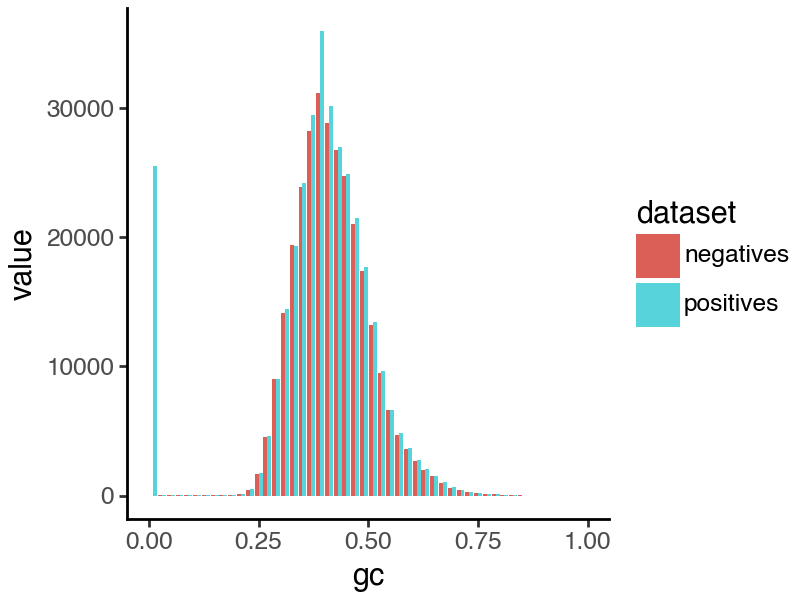

In [54]:
import grelu.visualize
grelu.visualize.plot_gc_match(
    positives=neural_crest_peaks, negatives=negatives, binwidth=0.02, genome="hg38", figsize=(4, 3)
)

## Combine peaks and negative regions

In [55]:
regions = pd.concat([neural_crest_peaks, negatives])
len(regions)

632022